In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
all_data = [1,2,3,4,5,6,7,8,9,10]
train, test = train_test_split(all_data, test_size=0.2, random_state=42)
train, test

([6, 1, 8, 3, 10, 5, 4, 7], [9, 2])

In [4]:
all_data = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
train, test = train_test_split(all_data, test_size=0.2, random_state=42)
train, test

(['6', '1', '8', '3', '10', '5', '4', '7'], ['9', '2'])

# Off-the-shelf model evaluation
Here we analyze the scores that the Perspective API gave to various tweets

In [2]:
dev_df = pd.read_csv('civility_data/dev.tsv', sep='\t')
demog_dev_df = pd.read_csv('civility_data/mini_demographic_dev.tsv', sep='\t')

In [3]:
# apply threshold to see which tweets Perspective thinks is toxic
threshold = 0.8

dev_df['is_offensive_pred'] = dev_df['perspective_score'] > threshold
demog_dev_df['is_offensive_pred'] = demog_dev_df['perspective_score'] > threshold

dev_df['is_offensive_true'] = dev_df['label'] == 'OFF'
demog_dev_df['is_offensive_true'] = False  # this dataset contains no offensive tweets

In [4]:
# accuracy and F1 score (offensive = positive class, not offensive = negative class)
from sklearn.metrics import f1_score

print('performance on dev.tsv:')
print('accuracy:', np.mean(dev_df['is_offensive_pred'] == dev_df['is_offensive_true']))
print('f1 score:', f1_score(
    1-dev_df['is_offensive_true'], 1-dev_df['is_offensive_pred'])
)  # flip labels: offensive should be negative class

print()

print('performance on mini_demographic_dev.tsv:')
print('accuracy:', np.mean(demog_dev_df['is_offensive_pred'] == demog_dev_df['is_offensive_true']))
print('f1 score:', f1_score(
    1-demog_dev_df['is_offensive_true'], 1-demog_dev_df['is_offensive_pred'])
)  # flip labels: offensive should be negative class

performance on dev.tsv:
accuracy: 0.7643504531722054
f1 score: 0.8472086190009795

performance on mini_demographic_dev.tsv:
accuracy: 0.9193611987381703
f1 score: 0.9579866461222394


4235 310
335 34
332 63
170 2


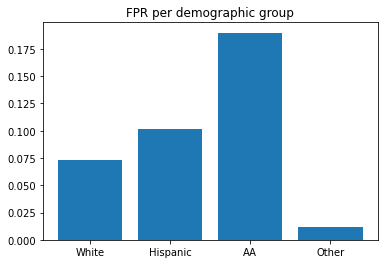

In [5]:
def fpr(y_true, y_pred):
    tot_neg = (y_true == False).sum()
    fp      = ((y_true == False) & (y_pred == True)).sum()
    print(tot_neg, fp)
    return fp/tot_neg

# report FPR for different demographic groups in demog_dev_df:
demog_fpr  = {
    demog: fpr(
        y_true = demog_dev_df[demog_dev_df['demographic'] == demog]['is_offensive_true'],
        y_pred = demog_dev_df[demog_dev_df['demographic'] == demog]['is_offensive_pred']
    ) for demog in demog_dev_df['demographic'].unique()
}

# plot
plt.figure()
plt.title('FPR per demographic group')
plt.bar(demog_fpr.keys(), demog_fpr.values())
plt.show()

In [6]:
demog_fpr

{'White': 0.07319952774498228,
 'Hispanic': 0.10149253731343283,
 'AA': 0.1897590361445783,
 'Other': 0.011764705882352941}

In [8]:
np.std(list(demog_fpr.values()))

0.06407265938020093

# Baseline custom model
We will follow this tutorial: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

In [9]:
train_df = pd.read_csv('civility_data/train.tsv', sep='\t')

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train_df['text'])
X_train_counts.shape

(10592, 16934)

In [11]:
count_vect.vocabulary_.get(u'the')

14978

Occurrence count is a good start but there is an issue: longer documents will have higher average count values than shorter documents, even though they might talk about the same topics.

To avoid these potential discrepancies it suffices to divide the number of occurrences of each word in a document by the total number of words in the document: these new features are called tf for Term Frequencies.

Another refinement on top of tf is to downscale weights for words that occur in many documents in the corpus and are therefore less informative than those that occur only in a smaller portion of the corpus.

This downscaling is called tf–idf for “Term Frequency times Inverse Document Frequency”.

Both tf and tf–idf can be computed as follows using TfidfTransformer:

In [12]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(10592, 16934)

Now that we have our features, we can train a classifier to try to predict the category of a post. Let’s start with a naïve Bayes classifier, which provides a nice baseline for this task. scikit-learn includes several variants of this classifier; the one most suitable for word counts is the multinomial variant:

In [13]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit( X_train_tfidf, (train_df['label']=='OFF') )

In order to make the vectorizer => transformer => classifier easier to work with, scikit-learn provides a Pipeline class that behaves like a compound classifier:

In [14]:
from sklearn.pipeline import Pipeline

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

text_clf.fit(train_df['text'], (train_df['label']=='OFF'))

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [15]:
# evaluate

train_pred = text_clf.predict(train_df['text'])
train_true = (train_df['label']=='OFF')
np.mean(train_pred == train_true)

0.7425415407854985

In [16]:
dev_pred = text_clf.predict(dev_df['text'])
dev_true = dev_df['is_offensive_true'].values

print('performance on dev.tsv:')
print('accuracy:', np.mean(dev_pred == dev_true))
print('f1 score:', f1_score(1-dev_true, 1-dev_pred))  # flip labels: offensive should be negative class
print()


demog_dev_pred = text_clf.predict(demog_dev_df['text'])
demog_dev_true = demog_dev_df['is_offensive_true'].values

print('performance on mini_demographic_dev.tsv:')
print('accuracy:', np.mean(demog_dev_pred == demog_dev_true))
print('f1 score:', f1_score(1-demog_dev_true, 1-demog_dev_pred))  # flip labels: offensive should be negative class

performance on dev.tsv:
accuracy: 0.7046827794561934
f1 score: 0.817545496966869

performance on mini_demographic_dev.tsv:
accuracy: 0.9487381703470031
f1 score: 0.9736948603804128


4235 185
335 20
332 52
170 3


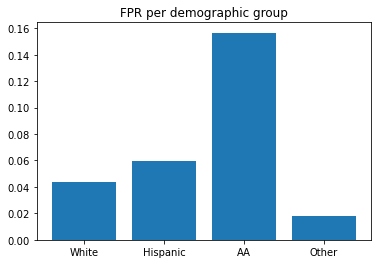

In [17]:
def fpr(y_true, y_pred):
    tot_neg = (y_true == False).sum()
    fp      = ((y_true == False) & (y_pred == True)).sum()
    print(tot_neg, fp)
    return fp/tot_neg

# report FPR for different demographic groups in demog_dev_df:
demog_fpr_custom  = {
    demog: fpr(
        y_true = demog_dev_df[demog_dev_df['demographic'] == demog]['is_offensive_true'],
        y_pred = text_clf.predict(demog_dev_df[demog_dev_df['demographic'] == demog]['text'])
    ) for demog in demog_dev_df['demographic'].unique()
}

# plot
plt.figure()
plt.title('FPR per demographic group')
plt.bar(demog_fpr_custom.keys(), demog_fpr_custom.values())
plt.show()

<AxesSubplot:xlabel='demographic'>

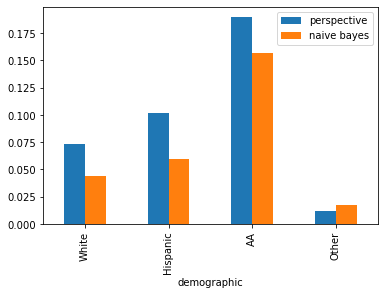

In [18]:
# side by side
demogs = list(demog_fpr_custom.keys())
demog_fpr_comparison_df = pd.DataFrame({
    'demographic': demogs,
    'perspective': [demog_fpr[demog] for demog in demogs],
    'naive bayes': [demog_fpr_custom[demog] for demog in demogs]
})
demog_fpr_comparison_df.plot(x = 'demographic', y = ['perspective', 'naive bayes'], kind='bar')

In [19]:
demog_fpr_custom

{'White': 0.043683589138134596,
 'Hispanic': 0.05970149253731343,
 'AA': 0.1566265060240964,
 'Other': 0.01764705882352941}

In [20]:
np.std(list(demog_fpr_custom.values()))

0.05254099411020251

In [17]:
# how many examples in each demographic?
demog_dev_df.groupby('demographic').count()

,text,perspective_score,is_offensive_pred,is_offensive_true
demographic,,,,
AA,332,332,332,332
Hispanic,335,335,335,335
Other,170,170,170,170
White,4235,4232,4235,4235


# Error analysis
Here we examine mistakes the Perspective model makes on dev set.

In [27]:
# grab incorrect predictions
perspective_error_df = dev_df[
      (dev_df['is_offensive_pred'] == True) 
    & (dev_df['is_offensive_true'] == False)
]
len(perspective_error_df)

19

In [28]:
perspective_error_df

,text,label,category,perspective_score,is_offensive_pred,is_offensive_true
47,@USER I'M SO FUCKING READY,NOT,NaN,0.871854,True,False
186,@USER No fucking way he said this!,NOT,NaN,0.883508,True,False
264,@USER @USER That's just modelling. Plenty of women make shit tons of money just for looking good,NOT,NaN,0.871575,True,False
304,@USER @USER @USER @USER @USER @USER @USER @USER Trash,NOT,NaN,0.837765,True,False
332,@USER @USER @USER don’t perpetuate colonialism. If you are going to talk about #puertorico you must have Puerto Ricans in the panel! Jeezuz.fucking.christ! How difficult can that be? #diásporaenresistencia URL,NOT,NaN,0.933502,True,False
405,#SJW crap and/or #Paedophilia .. #Hollywood #TV #Movies #Gaming #Politics #Comics #Police #PublicAuthorities like #Councils .. #DWP #DWPCrimes #CatholicChurch or #Church #Vatican #Islam and #Muslims used as a weapon .. Missed anything?! #NHS maybe? #MBGA #Conservatives,NOT,NaN,0.831707,True,False
410,@USER He’s gonna tip him two new assholes,NOT,NaN,0.904623,True,False
420,@USER @USER @USER I don't think you have a clue what leadership and liberals have the temperament of 2 year old children being told no....you have the intellectual brilliance of a goat.. please stop tweeting. TDS is making look quite the fool..,NOT,NaN,0.839066,True,False
503,@USER Hi has me energized. @USER He is such an idiot! I can’t believe he “surfaced” again.,NOT,NaN,0.946896,True,False
543,@USER IT'S FUCKING TIME!!,NOT,NaN,0.901701,True,False


The presence of swear words (fuck, fucking, shit, assholes, idiot, etc.) seems to confuse Perspective to think a tweet's offensive while it's actually not.

Let's look at the demographic dev set now:

In [29]:
# grab incorrect predictions
perspective_error_df = demog_dev_df[
      (demog_dev_df['is_offensive_pred'] == True) 
    & (demog_dev_df['is_offensive_true'] == False)
]
len(perspective_error_df)

409

In [31]:
perspective_error_df.sample(10)

,text,demographic,perspective_score,is_offensive_pred,is_offensive_true
2838,@USER fuck,White,0.957702,True,False
945,This chick looks miserable,White,0.904024,True,False
1136,I'm literally so sad now #FUCK,White,0.903893,True,False
691,Why are you so fucking strange? #juststop,White,0.963069,True,False
2264,@USER fuck for some reason I thought willmar in my head instead of Alex... #awkward,White,0.859588,True,False
4284,Holy shit holy shit holy shit holy shit,White,0.959326,True,False
1105,do whatever the fuck makes you happy because you know who's there for you in the end?\nyou.,White,0.837789,True,False
2713,"I'm sleepy, fuck yo laundry. Ima watch a movie.",Hispanic,0.950242,True,False
293,@USER Naw nigga .. You always want to see my body .. *Dials 911 * What's the number to the police station ? Shit fuck it HELPPPP,AA,0.950619,True,False
1492,Done thinking you done fucked your chance up just that quick. #Bye \ud83d\udc4b,White,0.830571,True,False
